In [1]:
using RNAStructPlot
using Graphs
using LinearAlgebra
using CairoMakie

sequence = "CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACAUUAUGAAGUG"
notation = "...(((((((..((((((.........))))))......)...))))))..."

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


"...(((((((..((((((.........))))))......)...))))))..."

In [2]:
rnatree = dotbrackettree(sequence, notation)
rnabase = dotbracketbase(sequence, notation)

RNABaseGraph(SimpleGraph{Int64}(64, [[2], [1, 3], [2, 4], [3, 5, 49], [4, 6, 48], [5, 7, 47], [6, 8, 46], [7, 9, 45], [8, 10, 44], [9, 11, 40]  …  [42, 44], [9, 43, 45], [8, 44, 46], [7, 45, 47], [6, 46, 48], [5, 47, 49], [4, 48, 50], [49, 51], [50, 52], [51]]), Dict{Any, Char}(5 => 'U', 16 => 'U', 20 => 'G', 35 => 'U', 30 => 'G', 19 => 'U', 32 => 'G', 49 => 'A', 6 => 'C', 45 => 'A'…), Dict{Any, Any}(5 => 48, 16 => 30, 7 => 46, 8 => 45, 17 => 29, 13 => 33, 6 => 47, 15 => 31, 4 => 49, 10 => 40…))

In [3]:
toradian(x, y) = (sqrt(x^2 + y^2), atan(x, y))
tocartesian(r, angle) = (r*cos(angle), r*sin(angle))

tocartesian (generic function with 1 method)

In [4]:
function paramline(x1, y1, x2, y2)
    m = (y2-y1)/(x2-x1)
    c = (y1-m*x1)
    return m, c
end

#https://math.stackexchange.com/questions/1398634/finding-a-perpendicular-vector-from-a-line-to-a-point
function intersection(m, c, x1, y1)
    x2 = x1 + (m*(y1-c))/(1+m^2)
    y2 = (m*x1+m^2*y1+c)/(1+ m^2)
    return [x2, y2]
end

intersection (generic function with 1 method)

In [5]:
function find_pairing((p1, p2), pairings)
    for (k, v) in pairings
        if (p1, p2) in v
            return k, v
        end
    end
    return missing
end

find_pairing (generic function with 1 method)

In [6]:
function intervalsize(start, stop, n)
    size = stop-start
    if size < 0
        size = n - abs(size)
    end
    return size
end

intervalsize (generic function with 1 method)

In [7]:
function anglebetween(v1, v2)
    return acos(clamp(dot(v1, v2)/(norm(v1)*norm(v2)), -1, 1))
end

anglebetween (generic function with 1 method)

In [8]:
normalizeangle(θ) = θ < 0 ? θ + 2*pi : θ

normalizeangle (generic function with 1 method)

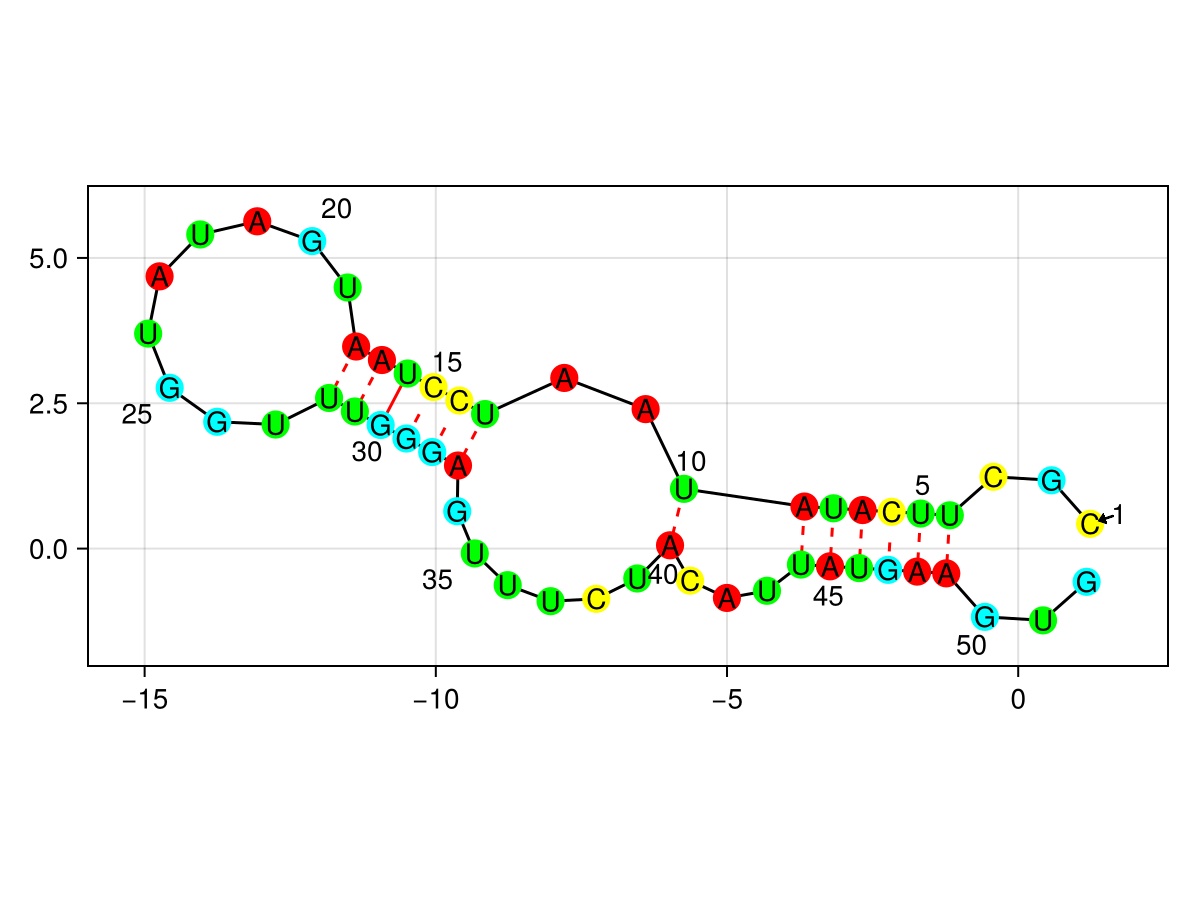

In [ ]:
using RNAStructPlot

function genadvanced(rnatree::RNATreeGraph, rnabase::RNABaseGraph)
    circular = gencircular(rnabase.graph)

    loops = sort(map(sort, collect(values(rnatree.loopbases)));by=minimum)
    stem = rnatree.regionpairs

    coords = Dict(v => [0.0, 0.0] for v in vertices(rnabase.graph))
    numberings = Dict(v => [0.0, 0.0] for v in vertices(rnabase.graph))

    z = sort(collect(keys(rnatree.loopbases)))
    pairing = [(k, v) for (k, v) in rnatree.pairings]

    function layoutloop(treevertex, circle)
        loop = loops[treevertex]
        loopsize = length(loop)

        # special case if loop only exists out of region stem pair
        considerations = loopsize <= 2 ? 0 : loopsize-1 

        # loop through possible pairs attached to loop and calculate their layout 
        for i in range(0, considerations)
            current = loop[i%loopsize+1]
            next = loop[(i+1)%loopsize+1]

            
            if hasexactpair(rnatree, current, next)
                (from, to), stempairs = find_pairing((current, next), stem)
                layoutstem(from, to, current, next, stempairs, circle)
            end
        end

        # layout remaining single bases in loop
        layoutsinglestrands(treevertex, circle)
    end

    function layoutstem(from, to, current, next, stempairs, fromcircle)
        # calculate chordnormal based on circular layout
        connection = connx, conny = circular[next] - circular[current] # direction from region pair 1 to 2
        perpendicular = perpx, perpy = -conny, connx # normal pointing outwards of the loop

        # lin. equation of line between region pairs
        slope, offset = paramline(
            circular[current][1],  circular[current][2],
            circular[next][1]    , circular[next][2]
        )
        # calculate intersection of orthogonal vector on line between region pairs on circle with (0, 0)
        cut = intersection(slope, offset, 0, 0)

        # calculate angle between outwards pointing normal and normalchord
        angle = anglebetween(perpendicular, (-1).*cut)
        chordnormal = normalize(cut)

        # orient chordnormal to point outwards the loop
        if abs(angle) > pi/2 
            chordnormal *= -1
        end
        chordangle = normalizeangle(atan(chordnormal[2], chordnormal[1]))
        
        # TODO fix for variable circle size
        currentangle = chordangle - pi/length(loops[from])
        nextangle    = chordangle + pi/length(loops[from])

        # calculate position of both starting region stem pairs
        currx, curry = fromcircle.center + fromcircle.radius .* [cos(currentangle), sin(currentangle)]
        nextx, nexty = fromcircle.center + fromcircle.radius .* [cos(nextangle),    sin(nextangle)   ]
        coords[current] = [currx, curry]
        coords[next]    = [nextx, nexty]

        direction = chordnormal/2 # TODO fix for variable circle size

        # walk along region stempairs and calculate their positions
        for (i, (low, high)) in enumerate(stempairs)
            coords[low]  = [coords[current][1], coords[current][2]] + direction*(i-1)
            coords[high] = [coords[next][1],    coords[next][2]   ] + direction*(i-1)

            numberings[high] = coords[high] + (coords[high] - coords[low])/2
            numberings[low] = coords[low] + (coords[low] - coords[high])/2
        end

        toloop = loops[to]
        toloopsize = length(toloop)
        
        # calculate dimensions for the circle of the next loop
        lastlow, lasthigh = last(stempairs)
        middle = coords[lastlow] + (coords[lasthigh] - coords[lastlow])/2

        toradius = 1/(2*sin(pi/toloopsize))
        tocenter = middle + normalize(chordnormal)*toradius
        tocircle = LoopCircle(toradius, tocenter)

        layoutloop(to, tocircle)
    end

    function layoutsinglestrands(treevertex, circle)
        loop = loops[treevertex]
        loopsize = length(loop)
        
        attachedpairs = []
        # collect all attached stem pairs by their index
        for i in range(0, loopsize-1)
            current = loop[i%loopsize+1]
            next = loop[(i+1)%loopsize+1]

            low, high = sort([current, next])
            if hasexactpair(rnatree, low, high)
                push!(attachedpairs, (i%loopsize+1, (i+1)%loopsize+1))
            end
        end

        # layout single strands inbetween the stem pairs
        for i in range(0, length(attachedpairs)-1)
            firstpair = attachedpairs[i%length(attachedpairs)+1]
            secondpair = attachedpairs[(i+1)%length(attachedpairs)+1]

            # calculate angular difference between both stem pairs
            startidx, stopidx = firstpair[2], secondpair[1]
            start = normalize(coords[loop[startidx]] - circle.center) 
            stop = normalize(coords[loop[stopidx]] - circle.center)
            startangle = normalizeangle(atan(start[2], start[1]))
            stopangle = normalizeangle(atan(stop[2], stop[1]))
            differenceangle = normalizeangle(stopangle-startangle)

            intervallength = intervalsize(startidx, stopidx, length(loop))
            segment = differenceangle/intervallength

            # in interval of length n there are n-1 bases 
            # (interval -: 6, bases b: 5) start-b-b-b-b-b-stop
            for i in range(1, intervallength-1)
                baseangle = startangle + segment*i
                basepos = circle.radius .* [cos(baseangle), sin(baseangle)] + circle.center
                
                # save base position and their numberings
                base = loop[(startidx+i-1)%loopsize+1]
                coords[base] = basepos
                numberings[base] = coords[base] + (coords[base] - circle.center) * 0.4
            end
        end
    end

    startcircle = LoopCircle(1/(2*sin(pi/length(loops[1]))), [0., 0.])
    layoutloop(1, startcircle)

    return DrawResult(coords, numberings)
end

result = genadvanced(rnatree, rnabase)

drawgeneric(rnabase, result)